In [10]:
import gym
from gym import wrappers
gym.logger.set_level(40)

import random
import numpy as np
import time
import os

import keras
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils import plot_model, to_categorical

from collections import deque

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from IPython.display import clear_output

In [4]:
print("I am running keras version %s."%keras.__version__)

I am running keras version 2.2.4.


# Policy Gradient

### Create PG Agent

In [5]:
class PG_Agent(object):

    def __init__(self, input_dim, output_dim):

        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.build_network(input_dim, output_dim)
        self.create_train_function()

    def build_network(self, input_dim, output_dim):
        """Create a network that learns a policy function (mapping state to action) """
        
        self.model = Sequential([
        Dense(24, activation='relu', input_shape=(input_dim,)),
        Dense(24, activation='relu'),
        Dense(output_dim, activation='softmax')])
            
        #print(self.model.summary())
               
    def create_train_function(self):
        """Create a train function for doing gradient descent after each episode
        """
        action_prob_placeholder = self.model.output
        action_onehot_placeholder = K.placeholder(shape=(None, self.output_dim),
                                                  name="action_onehot")
        discount_reward_placeholder = K.placeholder(shape=(None,),
                                                    name="discount_reward")

        # get the probability that corresponds to each action we took
            
        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        
        # take the log of each probability
        
        log_action_prob = K.log(action_prob)
        
        # -log prob * discounted cumulative future reward at each timestep
        # minus because instead of gradient ascent, we're doing gradient descent (i.e. minimise)
        
        loss = - log_action_prob * discount_reward_placeholder
    
        loss = K.sum(loss, axis=0)
        adam = Adam(lr=learning_rate)

        # update weights along the calculated gradient
        
        updates = adam.get_updates(params=self.model.trainable_weights,
                                   loss=loss)
       
        self.train_fn = K.function(inputs=[self.model.input,
                                           action_onehot_placeholder,
                                           discount_reward_placeholder],
                                   outputs=[],
                                   updates=updates)

    def get_action(self, state):
        """Returns an action at a given state
        """
        state = np.expand_dims(state, axis=0)
        
        # get probability distribution for the action space of the current state
        
        action_prob = np.squeeze(self.model.predict(state))
        
        # sample action given action_prob distribution
        
        return np.random.choice(np.arange(self.output_dim), p=action_prob)

    def fit(self, S, A, R):
        """Do gradient descent for each time step at the end of the episode 
           This is done along the state, a one-hot vector of the actions taken and the cumulative discounted future reward at each time step (from that point onwards)
        """
        action_onehot = to_categorical(A, num_classes=self.output_dim)
        discount_reward = self.compute_discounted_R(R, gamma)

        self.train_fn([S, action_onehot, discount_reward])
        
    def compute_discounted_R(self, R, gamma):
        """Returns discounted rewards
        """
        discounted_r = np.zeros_like(R, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(R))):

            running_add = running_add * gamma + R[t]
            discounted_r[t] = running_add

        discounted_r -= discounted_r.mean()
        discounted_r /= discounted_r.std()

        return discounted_r
    
    def plot(self, episode, means_hist, num_episodes, max_episode_steps, start):
        clear_output(True)
        print("--- Epoch: %i ---"%episode)
        print("--- Mean reward: %i ---"%means_hist[-1])
        print('time elapsed (sec) =', time.time()-start)

        size = (10, 5)
        fig, ax = pyplot.subplots(figsize=size)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=12)
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel('reward', fontsize=12)
        plt.xlim(0, num_episodes/10)
        plt.ylim(0, max_episode_steps)
        plt.plot(means_hist)

        if episode == num_episodes:
            plt.savefig('PG.png')

        plt.show()

        time.sleep(0.25)

###  Play the game and train the network as we go

In [6]:
def run_episode(env, agent, render):

    done = False

    # Lists for storing state, action and reward at each step
    # We will need this info in order to do gradient descent at the end of the episode
    
    S = []
    A = []
    R = []

    state = env.reset()

    cumul_reward_episode = 0

    while not done:

        # get action
        
        action = agent.get_action(state)

        # get next state, and reward
        
        next_state, reward, done, info = env.step(action)
        cumul_reward_episode += reward

        S.append(state)
        A.append(action)
        R.append(reward)

        # set state to the next_state
        
        state = next_state

        # if done to gradient descent and update model weights
        
        if done:
            S = np.array(S)
            A = np.array(A)
            R = np.array(R)

            agent.fit(S, A, R)

    return cumul_reward_episode

In [7]:
def pg_cartpole(num_episodes, max_episode_steps, render):
    try:
        
        start = time.time()
        
        mean_rewards = deque(maxlen=10)
        means_hist = []
        
        env = gym.make("CartPole-v0")
        env._max_episode_steps = max_episode_steps                      # set max steps
        #env = wrappers.Monitor(env, './videos/' + str(time()) + '/')
        
        input_dim = env.observation_space.shape[0]                      # define state space
        output_dim = env.action_space.n                                 # define action space
        
        # set up PG_Agent
        
        agent = PG_Agent(input_dim, output_dim)

        for episode in range(num_episodes):
            
            # run an episode
            
            cumul_reward_episode = run_episode(env, agent, render)               # start an episode along the current policy, retrieve reward and train model
            
            mean_rewards.append(cumul_reward_episode)
            
            if episode%10==0:

                means_hist.append(np.mean(mean_rewards))

                agent.plot(episode, means_hist, num_episodes, max_episode_steps, start)
        
    finally:
        env.close()

--- Epoch: 990 ---
--- Mean reward: 200 ---
time elapsed (sec) = 73.96839785575867


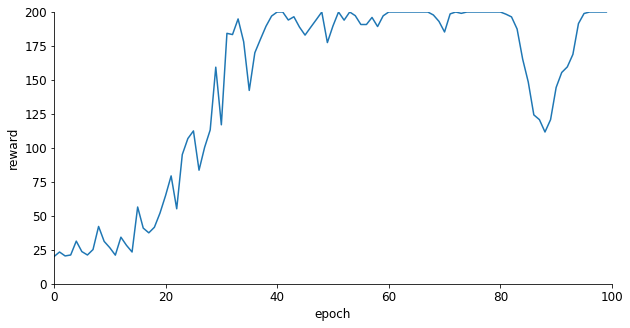

In [8]:
render = False
num_episodes = 1000
max_episode_steps = 200

gamma = 0.95
learning_rate = 0.001

pg_cartpole(num_episodes, max_episode_steps, render)